In [1]:
from collections import Counter
import os
import re

from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from sklearn.metrics import *
import pandas as pd
import torch

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
SEP       = os.path.sep
ROOT_PATH = SEP.join(os.getcwd().split(SEP)[:-3])
DATA_PATH = f'{ROOT_PATH}/Dataset/disaster tweets'

device  = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

MAX_LEN = 128
EPOCHS  = 30
BS      = 64
LR      = 5e-6

In [3]:
class DisasterDataset(Dataset):
    
    def __init__(self, data, labels, tokenizer, max_length, algo = 'bert', is_test = False):
        
        self.algo       = algo
        self.data       = data
        self.labels     = labels
        self.is_test    = is_test
        self.tokenizer  = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)
    
    
    def __getitem__(self, idx):
        
        text     = self.data[idx]
        
        if self.algo == 'bert':
            encoding = self.tokenizer.encode_plus(
                            text, max_length = self.max_length,
                            padding          = 'max_length',
                            truncation       = True,
                            return_tensors   = 'pt'
                        )
        
        elif self.algo == 'bart':
            encoding  = self.tokenizer(
                                       text, padding = 'max_length',
                                       truncation = True,
                                       max_length = self.max_length,
                                       return_tensors = 'pt'
                                      )
        
        input_ids      = encoding['input_ids'].squeeze()
        attention_mask = encoding['attention_mask'].squeeze()
        
        if self.is_test:
            return {'input_ids' : input_ids, 'attention_mask' : attention_mask}
        
        else:
            
            label = torch.tensor(self.labels[idx])
            return {'input_ids'      : input_ids, 
                    'attention_mask' : attention_mask,
                    'label'          : label}


In [4]:
def draw_distribution(y_values, is_single = True):
    
    if is_single:
        
        lb_cnt = Counter(y_values)
        plt.bar(lb_cnt.keys(), lb_cnt.values())
        
        for lb, cnt in lb_cnt.items():
            
            plt.text(lb, cnt, cnt,
                     va = 'bottom', ha = 'center')
            
    else:
        _, ax = plt.subplots(1, len(y_values), figsize = (5 * (len(y_values) + 1), 7))
        for idx, (dtype, y_value) in enumerate(zip(['train', 'valid'], y_values)):
            
            lb_cnt = Counter(y_value)
            
            ax[idx].bar(lb_cnt.keys(), lb_cnt.values())
            ax[idx].set_title(f'{dtype} data distribution')
            
            
            for lb, cnt in lb_cnt.items():
                ax[idx].text(lb, cnt, cnt,
                             va = 'bottom', ha = 'center')

                
def log_collector(hist, log, metric = 'loss', dtype = 'train'):
    
    hist[f'{dtype}_{metric}'].append(log)

In [5]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
model     = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels = 2)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias', 'classifier.we

In [6]:
train_df = pd.read_csv(f'{DATA_PATH}/train.csv')
test_df  = pd.read_csv(f'{DATA_PATH}/test.csv')

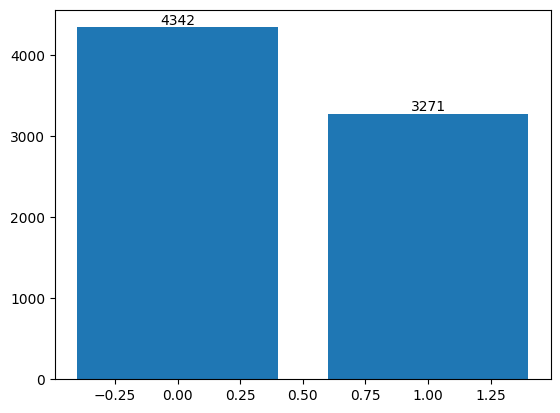

In [7]:
X, y     = train_df['text'].values, train_df['target'].values

draw_distribution(y, is_single = True)

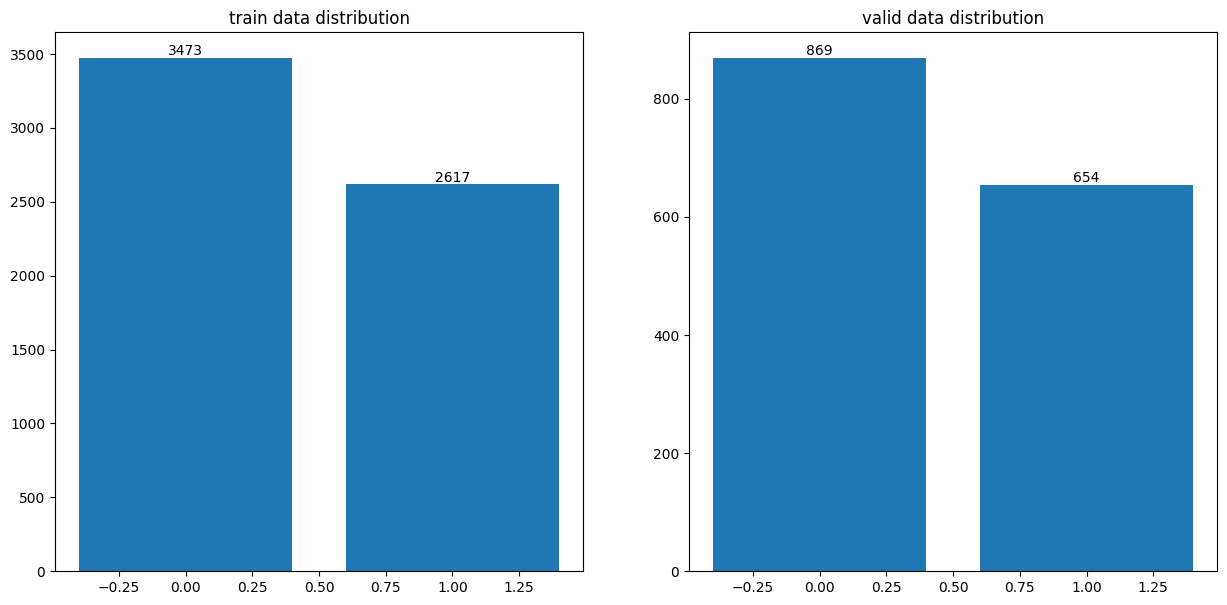

In [8]:
train_x, valid_x, train_y, valid_y = train_test_split(X, y, test_size = 0.2, shuffle = True,
                                                          random_state = 99, stratify = y)

draw_distribution([train_y, valid_y], is_single = False)

In [9]:
train_dataset = DisasterDataset(train_x, train_y, 
                                tokenizer = tokenizer, max_length = MAX_LEN)
valid_dataset = DisasterDataset(valid_x, valid_y, 
                                tokenizer = tokenizer, max_length = MAX_LEN)

train_loader  = DataLoader(train_dataset, BS, shuffle = True)
valid_loader  = DataLoader(valid_dataset, BS, shuffle = False)

In [10]:
def train(model, optim, train_loader, epoch):
    
    model.train()
    
    total_loss = 0
    total_acc  = 0.0
    for batch in train_loader:

        input_ids      = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels         = batch['label'].to(device)

        optim.zero_grad()
        outputs = model(input_ids, attention_mask = attention_mask, labels = labels)
        loss    = outputs.loss
        logits  = outputs.logits

        _, preds    = torch.max(logits, 1)
        total_acc  += torch.sum(preds == labels)
        total_loss += loss.item()
        loss.backward()
        optim.step()

    print(f'[TRAIN {epoch + 1} / {EPOCHS}] LOSS : {total_loss / len(train_loader):.3f} ACC : {total_acc * 100 / (BS * len(train_loader)):.1f} %')
    
    return (total_loss / len(train_loader), total_acc / (BS * len(train_loader)))


def valid(model, valid_loader, epoch):
    
    model.eval()
    total_loss, total_acc = 0, 0
    
    with torch.no_grad():
        
        for batch in valid_loader:
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels         = batch['label'].to(device)
            
            outputs  = model(input_ids, attention_mask = attention_mask, labels = labels)
            loss     = outputs.loss
            logits   = outputs.logits
            
            _, preds    = torch.max(logits, 1)
            total_acc  += torch.sum(preds == labels)
            total_loss += loss.item()
            
    print(f'[VALID {epoch + 1} / {EPOCHS}] LOSS : {total_loss / len(valid_loader):.3f} ACC : {total_acc * 100 / (BS * len(valid_loader)):.1f} %\n')
    return (total_loss / len(valid_loader), total_acc / (BS * len(valid_loader)))


def evaluate(model, data_loader):
    
    model.eval()
    

In [11]:
optim = torch.optim.AdamW(model.parameters(), lr = LR)
model.to(device)

hist = {
            'train_loss' : [], 'train_acc' : [],
            'valid_loss' : [], 'valid_acc' : []
        }

best_acc = 0.0
for epoch in range(EPOCHS):
    
    train_loss, train_acc = train(model, optim, train_loader, epoch)
    log_collector(hist, train_loss)
    log_collector(hist, train_acc.item(), metric = 'acc') 
    
    valid_loss, valid_acc = valid(model, valid_loader, epoch)
    log_collector(hist, valid_loss      , dtype = 'valid')
    log_collector(hist, valid_acc.item(), dtype = 'valid', metric = 'acc')
    
    if valid_acc > best_acc:
        
        print(f'best model changed with loss : {valid_loss:.3f}, acc : {valid_acc * 100:.1f} %\n')
        best_model = model
        best_acc   = valid_acc
    

/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


[TRAIN 1 / 30] LOSS : 0.564 ACC : 74.8 %
[VALID 1 / 30] LOSS : 0.427 ACC : 80.7 %

best model changed with loss : 0.427, acc : 80.7 %

[TRAIN 2 / 30] LOSS : 0.406 ACC : 82.3 %
[VALID 2 / 30] LOSS : 0.384 ACC : 83.1 %

best model changed with loss : 0.384, acc : 83.1 %

[TRAIN 3 / 30] LOSS : 0.366 ACC : 84.5 %
[VALID 3 / 30] LOSS : 0.378 ACC : 83.4 %

best model changed with loss : 0.378, acc : 83.4 %

[TRAIN 4 / 30] LOSS : 0.342 ACC : 85.8 %
[VALID 4 / 30] LOSS : 0.373 ACC : 84.4 %

best model changed with loss : 0.373, acc : 84.4 %

[TRAIN 5 / 30] LOSS : 0.315 ACC : 87.0 %
[VALID 5 / 30] LOSS : 0.380 ACC : 84.4 %

[TRAIN 6 / 30] LOSS : 0.287 ACC : 88.5 %
[VALID 6 / 30] LOSS : 0.386 ACC : 84.3 %

[TRAIN 7 / 30] LOSS : 0.268 ACC : 89.5 %
[VALID 7 / 30] LOSS : 0.421 ACC : 82.7 %

[TRAIN 8 / 30] LOSS : 0.250 ACC : 90.2 %
[VALID 8 / 30] LOSS : 0.426 ACC : 82.9 %

[TRAIN 9 / 30] LOSS : 0.224 ACC : 91.2 %
[VALID 9 / 30] LOSS : 0.413 ACC : 84.6 %

best model changed with loss : 0.413, acc : 8

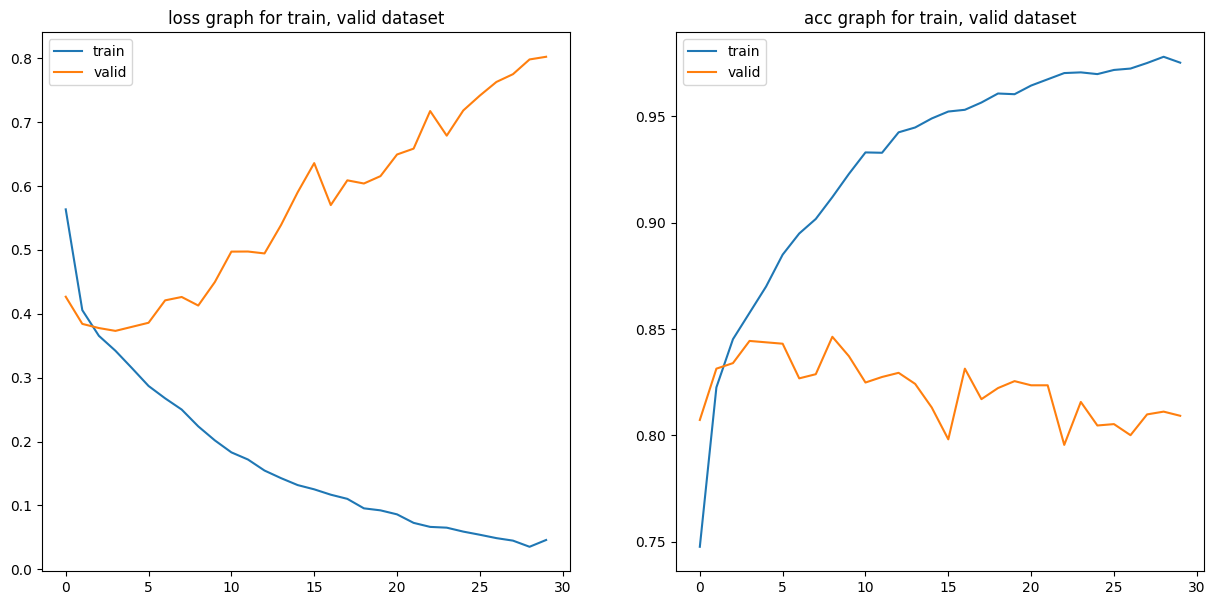

In [12]:
_, ax = plt.subplots(1, 2, figsize = (15, 7))

for idx, metric in enumerate(['loss', 'acc']):
    
    ax[idx].plot(range(EPOCHS), hist[f'train_{metric}'], label = 'train')
    ax[idx].plot(range(EPOCHS), hist[f'valid_{metric}'], label = 'valid')
    
    ax[idx].set_title(f'{metric} graph for train, valid dataset')
    ax[idx].legend(loc = 'best')

In [13]:
to_numpy = lambda x: x.detach().cpu().numpy() if x.requires_grad else x.cpu().numpy()

def evaluate(model, loader, has_label = True):
    
    pred_labels = []
    gt_labels   = []
    
    with torch.no_grad():
        for batch in loader:
            
            input_ids      = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            
            if has_label:
                labels   = batch['label'].to(device)
                outputs  = model(input_ids, attention_mask = attention_mask, labels = labels)
                gt_labels.extend(to_numpy(labels))
                
            else:
                outputs  = model(input_ids, attention_mask = attention_mask)
                
            logits   = outputs.logits
            _, preds = torch.max(logits, 1)

            pred_labels.extend(to_numpy(preds))
            
    return pred_labels, gt_labels

In [14]:
pred, gt = evaluate(model, train_loader)
print(classification_report(pred, gt))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3471
           1       0.99      0.99      0.99      2619

    accuracy                           0.99      6090
   macro avg       0.99      0.99      0.99      6090
weighted avg       0.99      0.99      0.99      6090



In [15]:
pred, gt = evaluate(model, valid_loader)
print(classification_report(pred, gt))

              precision    recall  f1-score   support

           0       0.84      0.84      0.84       867
           1       0.79      0.79      0.79       656

    accuracy                           0.82      1523
   macro avg       0.81      0.81      0.81      1523
weighted avg       0.82      0.82      0.82      1523



In [16]:
test_df      = pd.read_csv(f'{DATA_PATH}/test.csv')
test_dataset = DisasterDataset(test_df['text'], None, tokenizer, MAX_LEN, is_test = True)
test_loader  = DataLoader(test_dataset, 1, shuffle = False)

pred, _      = evaluate(model, test_loader, has_label = 0)

In [17]:
submission   = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
submission['target'] = pred

submission.to_csv('submission_DistilBERT.csv', index = False)
submission.head()

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1


In [18]:
tokenizer = AutoTokenizer.from_pretrained("IT-community/BART_cnn_news_text_classification")
model     = AutoModelForSequenceClassification.from_pretrained("IT-community/BART_cnn_news_text_classification")

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'business', '1': 'entertainment', '2': 'health', '3': 'news', '4': 'politics', '5': 'sport'}. The number of labels wil be overwritten to 6.


In [19]:
train_dataset = DisasterDataset(train_x, train_y, algo = 'bart',
                                tokenizer = tokenizer, max_length = MAX_LEN)
valid_dataset = DisasterDataset(valid_x, valid_y, algo = 'bart',
                                tokenizer = tokenizer, max_length = MAX_LEN)

train_loader  = DataLoader(train_dataset, BS, shuffle = True)
valid_loader  = DataLoader(valid_dataset, BS, shuffle = False)

In [20]:
LR     = 5e-7
EPOCHS = 50

optim = torch.optim.AdamW(model.parameters(), lr = LR)
model.to(device)

hist = {
            'train_loss' : [], 'train_acc' : [],
            'valid_loss' : [], 'valid_acc' : []
        }

best_acc = 0.0
for epoch in range(EPOCHS):
    
    train_loss, train_acc = train(model, optim, train_loader, epoch)
    log_collector(hist, train_loss)
    log_collector(hist, train_acc.item(), metric = 'acc') 
    
    valid_loss, valid_acc = valid(model, valid_loader, epoch)
    log_collector(hist, valid_loss      , dtype = 'valid')
    log_collector(hist, valid_acc.item(), dtype = 'valid', metric = 'acc')
    
    
    if valid_loss > best_acc:
        
        print(f'best model changed with loss : {valid_loss:.3f}, acc : {valid_acc * 100:.1f} %\n')
        best_acc   = valid_acc
        best_model = model

[TRAIN 1 / 50] LOSS : 3.872 ACC : 4.0 %
[VALID 1 / 50] LOSS : 2.987 ACC : 8.5 %

best model changed with loss : 2.987, acc : 8.5 %

[TRAIN 2 / 50] LOSS : 1.944 ACC : 24.8 %
[VALID 2 / 50] LOSS : 1.455 ACC : 39.7 %

best model changed with loss : 1.455, acc : 39.7 %

[TRAIN 3 / 50] LOSS : 1.131 ACC : 49.0 %
[VALID 3 / 50] LOSS : 1.022 ACC : 54.3 %

best model changed with loss : 1.022, acc : 54.3 %

[TRAIN 4 / 50] LOSS : 0.868 ACC : 58.9 %
[VALID 4 / 50] LOSS : 0.856 ACC : 59.6 %

best model changed with loss : 0.856, acc : 59.6 %

[TRAIN 5 / 50] LOSS : 0.744 ACC : 63.8 %
[VALID 5 / 50] LOSS : 0.752 ACC : 62.4 %

best model changed with loss : 0.752, acc : 62.4 %

[TRAIN 6 / 50] LOSS : 0.679 ACC : 66.6 %
[VALID 6 / 50] LOSS : 0.693 ACC : 65.0 %

best model changed with loss : 0.693, acc : 65.0 %

[TRAIN 7 / 50] LOSS : 0.637 ACC : 68.4 %
[VALID 7 / 50] LOSS : 0.635 ACC : 67.1 %

[TRAIN 8 / 50] LOSS : 0.604 ACC : 70.9 %
[VALID 8 / 50] LOSS : 0.602 ACC : 69.6 %

[TRAIN 9 / 50] LOSS : 0.571

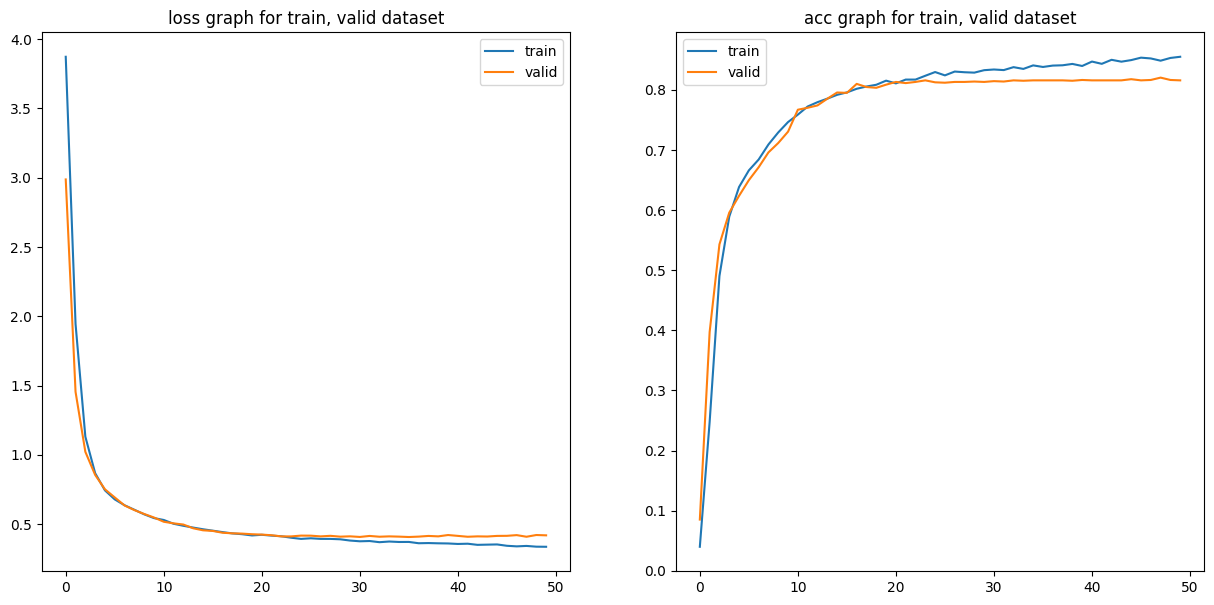

In [21]:
_, ax = plt.subplots(1, 2, figsize = (15, 7))

for idx, metric in enumerate(['loss', 'acc']):
    
    ax[idx].plot(range(EPOCHS), hist[f'train_{metric}'], label = 'train')
    ax[idx].plot(range(EPOCHS), hist[f'valid_{metric}'], label = 'valid')
    
    ax[idx].set_title(f'{metric} graph for train, valid dataset')
    ax[idx].legend(loc = 'best')

In [22]:
pred, gt = evaluate(best_model, train_loader)
print(classification_report(pred, gt))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      3551
           1       0.83      0.86      0.85      2538
           2       0.00      0.00      0.00         1

    accuracy                           0.87      6090
   macro avg       0.58      0.58      0.58      6090
weighted avg       0.87      0.87      0.87      6090



/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/envs/torch_1.x/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
pred, gt = evaluate(best_model, valid_loader)
print(classification_report(pred, gt))

              precision    recall  f1-score   support

           0       0.84      0.85      0.84       861
           1       0.80      0.79      0.79       662

    accuracy                           0.82      1523
   macro avg       0.82      0.82      0.82      1523
weighted avg       0.82      0.82      0.82      1523



In [24]:
test_df      = pd.read_csv(f'{DATA_PATH}/test.csv')
test_dataset = DisasterDataset(test_df['text'], None, tokenizer, MAX_LEN, is_test = True)
test_loader  = DataLoader(test_dataset, 1, shuffle = False)

pred, _      = evaluate(best_model, test_loader, has_label = 0)

In [25]:
submission   = pd.read_csv(f'{DATA_PATH}/sample_submission.csv')
submission['target'] = pred

submission.to_csv('submission_BART.csv', index = False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


# :+1: REF CODES
- Kaggle : [DistilBERT]Know, Train & Infer | [[LINK]](https://www.kaggle.com/code/suraj520/distilbert-know-train-infer)